In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import os

## Introduction
With the climbing vaccine rate, tourism-related businesses are about to boom, so it’s imperative to identify the characteristics of customers group and offer customized products. This report aims to explore (1) how to pre-process complicate customers' information (2) how potential customers with common characteristics can be divided into groups based on basic information about them. (3) how to describe the characteristics of groups based on model results. There will be 4 parts in the main content of this report: Data Exploration, Data Pre-processing, K-means clustering, Analysis characteristics of different groups.

In [67]:
tra_data = pd.read_csv('data_travel.csv', skipinitialspace = True)
tra_data.head(10)

,interested_travel,computer_owner,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,interested_golf,interested_gambling,HH_has_children,HH_adults_num,interested_reading
0,NaN,NaN,64,124035,73,932,3,312,420,149,96,626,0,0,NaN,NaN,0
1,0.0,1.0,69,138574,73,1000,7,241,711,263,68,658,0,0,N,5.0,3
2,0.0,0.0,57,148136,77,688,1,367,240,240,56,354,0,1,N,2.0,1
3,1.0,1.0,80,162532,74,932,7,291,832,197,86,462,1,1,Y,2.0,3
4,1.0,1.0,48,133580,77,987,10,137,121,209,42,423,0,1,Y,3.0,3
5,NaN,NaN,63,205612,72,945,4,302,257,96,91,464,0,0,NaN,NaN,0
6,0.0,0.0,78,190937,74,759,2,422,749,252,80,467,1,0,N,3.0,1
7,1.0,1.0,39,117466,78,356,10,172,373,122,64,374,0,0,Y,3.0,2
8,1.0,1.0,63,119947,71,1000,5,242,201,305,56,546,0,0,N,3.0,2
9,1.0,1.0,46,130747,71,863,10,236,128,270,49,575,1,0,Y,3.0,3


## Data exploration
The CSV file’data_travel.csv’ (9463KB) has 167177 rows and 17 columns, each row corresponds to a customer and each column corresponds to an attribute of basic information about customers. There are numerical variables, ordinal variables, and nominal variables. First, noted the way to represent a certain type of attributes is not consistent, like HH_has_children, which supposes to be a categorical variable using 0/1 as others, however, it uses ‘Y/N’ instead. Second, dealing with 17 attributes simultaneously will be unrealistic, which may lead to an uninterpretable result, so reducing the dimensionality of feature space is a must. Third, since the goal is to group customers with similar characteristics, K-means clustering will be applied, however, it only works with numerical data, certain conversion will be done.
As shown in the figure, there is a summary of this dataset.

In [68]:
tra_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167177 entries, 0 to 167176
Data columns (total 17 columns):
interested_travel      149788 non-null float64
computer_owner         149788 non-null float64
age                    167177 non-null int64
home_value             167177 non-null int64
loan_ratio             167177 non-null int64
risk_score             167177 non-null int64
marital                167177 non-null int64
interested_sport       167177 non-null int64
HH_grandparent         167177 non-null int64
HH_dieting             167177 non-null int64
HH_head_age            167177 non-null int64
auto_member            167177 non-null int64
interested_golf        167177 non-null int64
interested_gambling    167177 non-null int64
HH_has_children        159899 non-null object
HH_adults_num          145906 non-null float64
interested_reading     167177 non-null object
dtypes: float64(3), int64(12), object(2)
memory usage: 21.7+ MB


### 1) FillIng N/A
We can see missing values only exist in attribute 'interested_travel', 'computer_owner', 'HH_has_children', 'HH_adults_num'. Most of these attributes are binary and the percentage of missing values is relatively low, so mode method was applied to filling N/A values.

In [69]:
tra_data.isnull().sum()/len(tra_data)

interested_travel      0.104016
computer_owner         0.104016
age                    0.000000
home_value             0.000000
loan_ratio             0.000000
risk_score             0.000000
marital                0.000000
interested_sport       0.000000
HH_grandparent         0.000000
HH_dieting             0.000000
HH_head_age            0.000000
auto_member            0.000000
interested_golf        0.000000
interested_gambling    0.000000
HH_has_children        0.043535
HH_adults_num          0.127236
interested_reading     0.000000
dtype: float64

In [4]:
lost_cols = ['interested_travel', 'computer_owner', 'HH_has_children','HH_adults_num']
lost_values = {col: tra_data[col].mode()[0] for col in lost_cols}
tra_data = tra_data.fillna(lost_values)

### 2) Converting data
Attribute 'HH_has_children' is a binary variable using ‘Y’ and ‘N’ as an indicator. For consistency with other binary variables (interested_travevl, computer_owner), HH_has_children was converted into ‘0.0’ and ‘1.0’. In addition, attribute interested_reading should be 'int' type, but it is 'object' type, and value ‘.’ represents ‘not sure if the person is interested in reading’, so ‘.’ was be replaced with 0 and this attribute was converted into int type. 

In [5]:
tra_data['interested_reading'].value_counts(dropna = False)

3    65096
1    43832
0    32919
2    24488
.      842
Name: interested_reading, dtype: int64

In [6]:
tra_data['interested_reading'] = tra_data['interested_reading'].replace({'.':'0'}).astype('int') 
tra_data['HH_has_children'] = tra_data['HH_has_children'].replace({'N':'0.0', 'Y':'1.0', np.NaN: 0.0})

### 3) Dealing with categorical variables
Observing categorical variable: 'interested_travel','computer_owner','marital',
'interested_golf', 'interested_gambling', 'HH_has_children','interested_reading', notice there are a few attributes describing interests in interest aspect, the difference between these similar attributes can be ignored considering our topic, so Chi-square test was applied to analyze the correlation between each two of these variables (threshold a=0.05) and to see if it’s possible to generalize interest-related attributes with a new attribute.

In [7]:
_fields = [
'interested_travel',
'computer_owner',
'marital',
'interested_golf',
'interested_gambling',
'HH_has_children',
'interested_reading'
]
sample = tra_data[_fields].sample(3000, random_state = 12345)

In [9]:
from itertools import combinations
from scipy import stats

for a_col, b_col in combinations(_fields, 2):#两两组合
    crosstab = pd.crosstab(sample[a_col], sample[b_col])
    p_value = stats.chi2_contingency(crosstab)[1]
    if p_value > 0.05:
        print('p-value = %0.3f between "%s" and "%s"' %(p_value, a_col, b_col))

p-value = 0.710 between "interested_travel" and "HH_has_children"
p-value = 0.495 between "computer_owner" and "HH_has_children"
p-value = 0.272 between "interested_golf" and "HH_has_children"


As can be seen from results, only HH_has_children is independent with interested_travel, computer_owner, interested_golf, which means other variables are more correlated, so it’s practical to combine 'interested_travel', 'computer_owner', 'interested_golf', 'interested_gambling', 'interested_reading' as a new attribute ’span_of_interest’ to generalize these information. Before combing, we noticed interested_reading is an ordinal variable having 4 values (0,1,2,3), to be consistent with others, a threshold was selected to convert it into a binary variable (threshold = 1.5).

In [10]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold = 1.5) 
tra_data['interested_reading'] = binarizer.fit_transform(tra_data[['interested_reading']])

In [11]:
span_of_interest = ['interested_travel', 'computer_owner', 'interested_golf',
'interested_gambling', 'interested_reading'] 
tra_data['span_of_interest'] = tra_data[span_of_interest].sum(axis = 1)
tra_data = tra_data.drop(span_of_interest, axis = 1)

### 4) Rescaling attributes
#### Normalization:
Most machine learning algorithms prefer a standard probability distribution with input data to have better performance. Due the original distribution of numerical data is queit skewed (seen in below figures), quantiletransfomer from sklearn was applied to spread out the most frequent values and reduces the impact of (marginal) outliers.

In [13]:
con_var = ['age', 'home_value', 'loan_ratio', 'risk_score', 'interested_sport',
           'HH_grandparent', 'HH_dieting', 'HH_head_age', 'auto_member']
cat_var = ['marital', 'span_of_interest', 'HH_adults_num']
dis_var = ['HH_has_children']

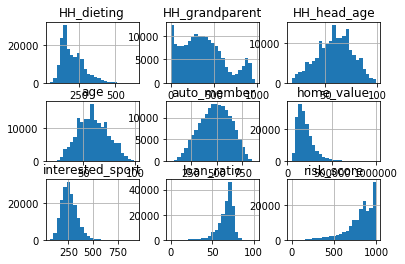

In [14]:
copy_data = tra_data.copy() #Copy the original dataset to prevent errors
copy_data[con_var].hist(bins=25)
plt.show()

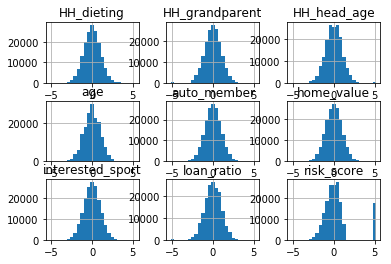

In [15]:
from sklearn.preprocessing import QuantileTransformer 
qt = QuantileTransformer(output_distribution = 'normal') 
copy_data[con_var] = qt.fit_transform(copy_data[con_var]) 
copy_data[con_var].hist(bins = 25)
plt.show()

#### Standardization:
For ordinal variable, which have different units in measurements, to make sure variables contribute equally to the analysis and avoid creating baises, scale method from sklearn was applied.

In [16]:
from sklearn.preprocessing import scale 
copy_data[cat_var] = scale(copy_data[cat_var])

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,span_of_interest
0,0.321611,-0.896042,0.695908,0.584984,-1.487818,0.734798,0.263985,-0.510631,2.575483,0.849874,0.0,-0.547836,-1.035281
1,0.631785,-0.629959,0.695908,5.199338,0.044429,-0.138444,1.179402,0.824933,0.461215,1.077446,0.0,1.895118,-0.354828
2,-0.127052,-0.469466,1.562721,-0.939747,-2.253942,1.321946,-0.447305,0.522099,-0.235509,-0.807429,0.0,-0.547836,-1.035281
3,1.327982,-0.255626,0.922330,0.584984,0.044429,0.499230,1.407905,0.110627,1.639539,-0.172731,1.0,-0.547836,1.686529
4,-0.752997,-0.715093,1.562721,1.135284,1.193615,-1.811457,-0.931971,0.222630,-0.985610,-0.404717,1.0,0.266482,1.006077


### 5) Reduction of dimentionality
To achieve a better performance in k-means algorithm, principal components analysis (PCA) was applied. Firstly, to avoid k-means focusing on a specific aspect of the data, variables were divided into 2 groups: Client's property and family status(family), Client's personal preference(hobby), then applied PCA was applied individually to each group.  

In [17]:
family = ['age', 'home_value', 'loan_ratio', 'risk_score', 'marital',
'HH_grandparent', 'HH_head_age', 'HH_adults_num']
hobby = ['interested_sport', 'HH_dieting', 'auto_member', 'span_of_interest' ]

#### PCA analysis
As the results show, for the client's property and family status(famliy), keeping 4 components can have 82% of the data be explained.

In [62]:
#famaliy
from sklearn.decomposition import PCA
pca_HH = PCA().fit(copy_data[family])
print('Cumulative variance contribution rate',pca_HH.explained_variance_ratio_.cumsum())

Cumulative variance contribution rate [0.3522971  0.5644875  0.72987523 0.829736   0.88399445 0.92827076
 0.96678746 1.        ]


Then fa_kit from FactorAnalysis was used to extract the principal component with method=’top_n’, num_keep=4.

In [21]:
from fa_kit import FactorAnalysis 
from fa_kit import plotting as fa_plot

In [22]:
fa_HH = FactorAnalysis.load_data_samples(copy_data[family].values,preproc_demean = True,preproc_scale = True)
fa_HH.extract_components() 
fa_HH.find_comps_to_retain(method='top_n',num_keep=4)

array([0, 1, 2, 3], dtype=int64)

Then we rotated components with variance maximization to gain a more polarized distribution of loading factors on each attribute.

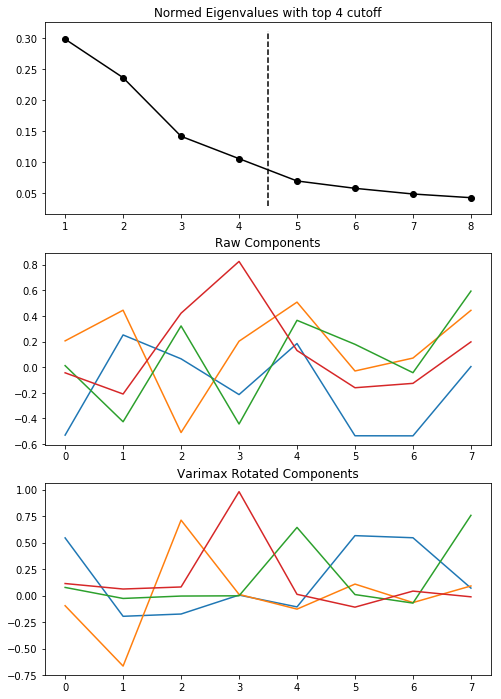

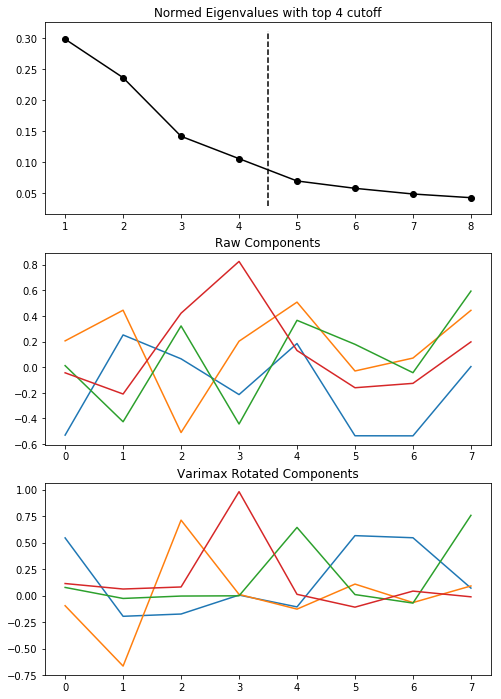

In [23]:
fa_HH.rotate_components(method='varimax') 
fa_plot.graph_summary(fa_HH)

Printed out the factor loading matrix

In [24]:
pd.DataFrame(fa_HH.comps['rot'].T, columns=family)

,age,home_value,loan_ratio,risk_score,marital,HH_grandparent,HH_head_age,HH_adults_num
0,0.544654,-0.195409,-0.173852,0.004950,-0.106594,0.566020,0.546043,0.070810
1,-0.095265,-0.665218,0.712440,0.011598,-0.127585,0.108734,-0.065730,0.091010
2,0.077166,-0.026870,-0.004273,-0.001897,0.643573,0.009722,-0.070624,0.757649
3,0.113927,0.062108,0.081460,0.981098,0.012171,-0.109027,0.042510,-0.011462


From the factor loading matrix, we can see the first component has higher weights on age, HH_grandparent, HH_head_age, so we can take these three as the customers’ age. The second component has higher weights on loan_ratio, home_value, so we can take these two as the customers’ financial condition. The third component has higher weights on risk, so we can take it as the customers’ risk factor. Base on these analysis, we recalculated the score of these 4 components with new attribute names [‘age_stage', 'money', 'population', 'risk'] in a reduced data frame. 

In [26]:
data_HH = pd.DataFrame( np.dot(copy_data[family], fa_HH.comps['rot']),columns=['age_stage', 'money', 'population', 'risk'])

A similar analysis was done on Client's personal preference(hobby). Creating a reduced data frame with 3 new attributes['sports', 'health', 'leisure']

In [61]:
#hobby
pca_HB = PCA().fit(copy_data[hobby]) 
print('Cumulative variance contribution rate',pca_HB.explained_variance_ratio_.cumsum())

Cumulative variance contribution rate [0.49020983 0.71623162 0.91081282 1.        ]


In [29]:
fa_HB = FactorAnalysis.load_data_samples(copy_data[hobby].values,preproc_demean = True,preproc_scale = True)
fa_HB.extract_components() 
fa_HB.find_comps_to_retain(method='top_n',num_keep=3)

array([0, 1, 2], dtype=int64)

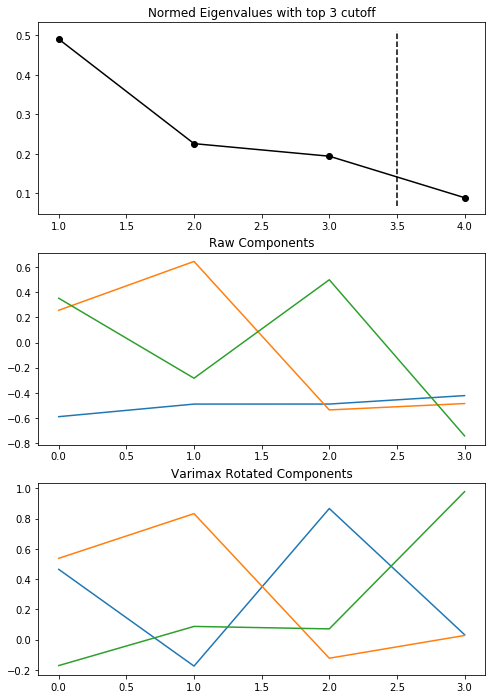

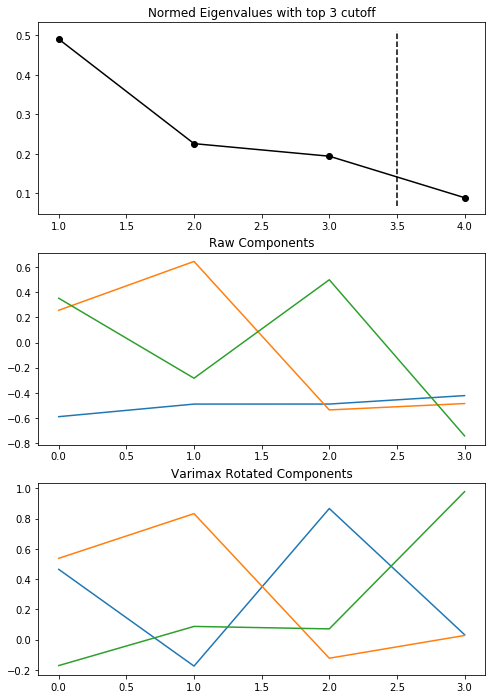

In [71]:
fa_HB.rotate_components(method='varimax') 
fa_plot.graph_summary(fa_HB)

In [31]:
data_HB = pd.DataFrame(np.dot(copy_data[hobby], fa_HB.comps['rot']),columns= ['sports', 'health', 'leisure'])

## k-means

### 1)Optimal k value selection

In [38]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score 
import warnings
warnings.filterwarnings("ignore")

In order to make the model the most interpretable, the sum of squares of cluster deviations and the silhouette_score coefficient and the CH coefficient are used to comprehensively select the optimal K value. The definition function is as follows:

In [35]:
def cluster_plot(data, k_range = range(2, 12), n_init=5, sample_size = 2000, n_jobs=-1): 
    seed = [] 
    cs = {} 
    sil = [] 
    ch = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k,n_init=n_init ,n_jobs=n_jobs)
        kmeans.fit(data) 
        cs[k]=kmeans
        seed.append(kmeans.inertia_)
        sil.append(silhouette_score(data, kmeans.labels_, sample_size = sample_size)) 
        ch.append(calinski_harabasz_score(data,kmeans.labels_))
    plt.subplot(221, ylabel = 'sum_square') 
    plt.plot(range(2,12),seed)
    plt.subplot(222, ylabel = 'silhouette_score') 
    plt.plot(range(2,12),sil)
    plt.subplot(223, ylabel = 'calinski_harabaz_score') 
    plt.plot(range(2,12),ch)
    plt.show()
    return cs

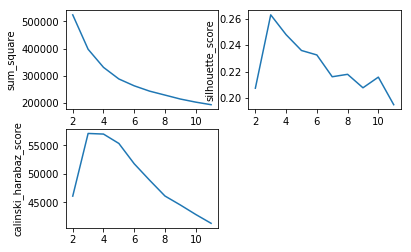

In [39]:
#family
scale_data_HH = scale(data_HH) 
models_HH = cluster_plot(scale_data_HH)

It can be seen that the variation of the sum of square deviations within the cluster has a significant slowing trend after k>3, and the contour coefficient reaches the highest peak at k=4, and the value of the integrated CH coefficient is also the largest at k 4. Since the sum of squared deviations, that is, the value of the loss function, should be as small as possible, it is better to determine k=4 in summary.

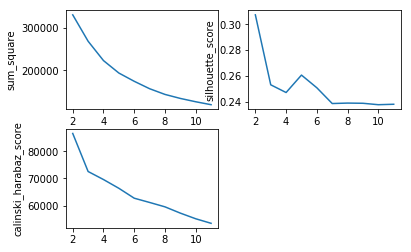

In [40]:
# interest
scale_data_HB = scale(data_HB)
models_HB = cluster_plot(scale_data_HB)

When using customers’ interest preferences for sample clustering, it can be observed that both the profile coefficient and the CH coefficient reach their peak at k=2. The more cluster classification categories, the greater the loss function, and the general selection has the largest downward trend. When K is selected as the range of K value, the downward trend becomes gentle after K=4. Considering the result chart, choose k=3 for cluster analysis.

In order to make the selection of the k value more convincing and intuitive, here is an attempt to use a scatter plot to verify whether the k value of the two attributes is optimal. First make a scatter plot of the original data:

<function matplotlib.pyplot.show>

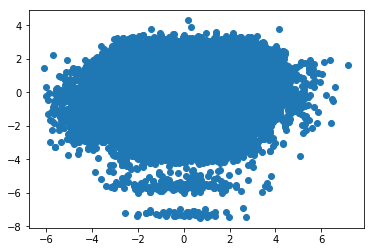

In [41]:
# family
from sklearn import metrics
X = np.array(data_HH)
plt.scatter(X[:,0], X[:,1], marker='o')
plt.show

Then substitute different k values through the loop to draw scatter plots under different clustering effects:

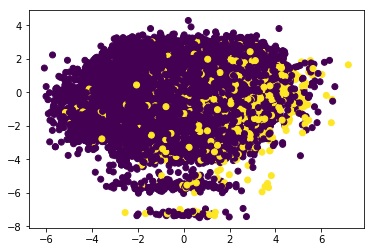

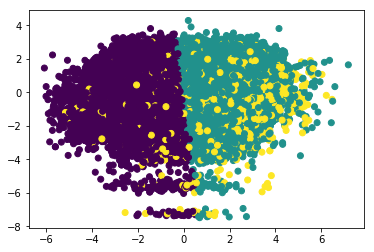

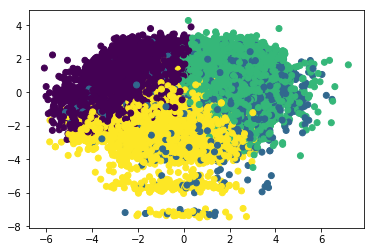

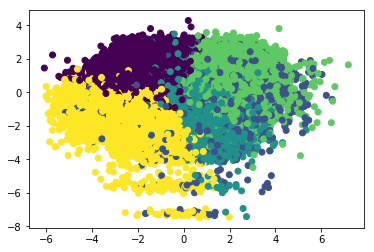

In [43]:
score_all =[]
list1 =range(2,6)
for k in range(2,6):
        y_seed = KMeans(n_clusters=k,n_init=5 ,n_jobs=-1).fit_predict(X)
        plt.scatter(X[:,0], X[:,1], c=y_seed)
        plt.show()

Combining the situation of the scatter plot and the result of the contour coefficient, it is known that k=4 is the optimal k value of the attribute sample. In the same way, the same verification and analysis are performed on the selection of the customer's interest preference attribute k value:

<function matplotlib.pyplot.show>

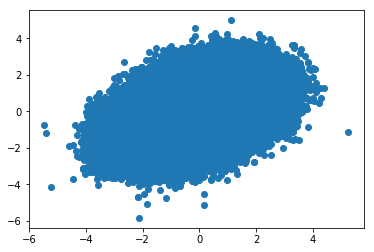

In [45]:
# interest
Y = np.array(data_HB)
plt.scatter(Y[:,0], Y[:,1], marker='o')
plt.show

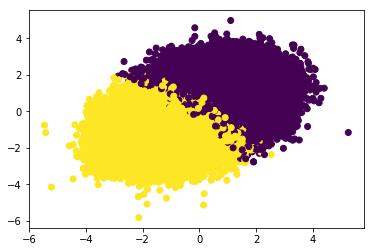

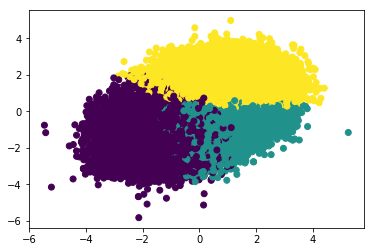

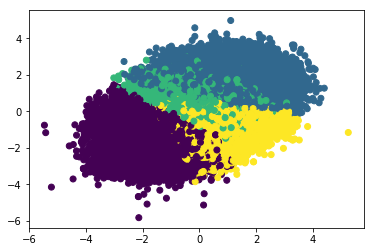

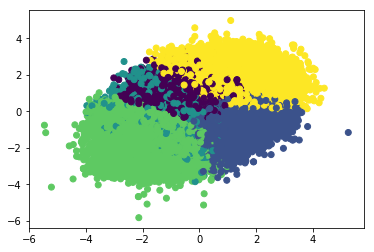

In [46]:
score_all =[]
for k in range(2,6):
    y_seed = KMeans(n_clusters=k,n_init=5 ,n_jobs=-1).fit_predict(Y)
    plt.scatter(Y[:,0], Y[:,1], c=y_seed)
    plt.show()

Therefore, combining the situation of the scatter plot and the result of the contour coefficient, it is known that k=3 is the optimal k value of the attribute sample.

## Characterization of each cluster

After selecting the value of k, use simple data visualization to analyze the eigenvalues. Categorize the corresponding groups and observe different characteristics.
In order to obtain a more reliable model classification, we will continue to use decision trees for feature description in the following steps.

### Famliy and property

In [47]:
# family
model_hh = KMeans(n_clusters=4,n_init=15,n_jobs=-1)
model_hh.fit(data_HH)
data_HH['type'] = model_hh.labels_

model_hb = KMeans(n_clusters=3,n_init=15,n_jobs=-1)
model_hb.fit(data_HB)
data_HB['type'] = model_hb.labels_

from pyecharts import Pie

attr = ['Group 1','Group 2','Group 3','Group 4']
v1 = data_HH.groupby('type').count().iloc[:,1]
pie = Pie("Proportion of family/property classification group")
pie.add("", attr, v1, is_label_show=True,radius=[20, 60])
pie

In [50]:
hh = data_HH.groupby('type').mean()
from pyecharts import Radar
c_schema=[]
for i in hh.columns:
    dict = {}
    dict['name'] = i
    dict['max'] = 6
    dict['min'] = -2
    c_schema.append(dict)
radar = Radar()
color = ['#50514F','#F25F5C','#FFE066','#1874CD']
radar.config(c_schema=c_schema,shape='circle')
for i in range(4):
    radar.add('Group%i'%(i+1),[hh.iloc[i]],is_area_show=True,area_opacity=0.6,area_color=color
[i])
radar

Observing the above figure, we can get four clustering groups:

Group 1: The burden of the family population is relatively large, the economic situation is average, and the credit risk is average

Group 2: Longevity, certain savings, but higher credit risk

Group 3: Longevity, certain savings, low credit risk

Group 4: Good economic situation, single, young

Among them, group 1 has a relatively large number of people, and group 3 has a relatively small number of people

In [63]:
cluster = tra_data.copy()
label_names = ['hh', 'hb']
labels = np.vstack([model_hh.labels_, model_hb.labels_]).T
clusters = cluster.join(pd.DataFrame(labels, columns=label_names))
clusters.head()

,age,home_value,loan_ratio,risk_score,marital,interested_sport,HH_grandparent,HH_dieting,HH_head_age,auto_member,HH_has_children,HH_adults_num,span_of_interest,hh,hb
0,64,124035,73,932,3,312,420,149,96,626,0.0,2.0,1.0,1,0
1,69,138574,73,1000,7,241,711,263,68,658,0.0,5.0,2.0,2,2
2,57,148136,77,688,1,367,240,240,56,354,0.0,2.0,1.0,3,2
3,80,162532,74,932,7,291,832,197,86,462,1.0,2.0,5.0,1,0
4,48,133580,77,987,10,137,121,209,42,423,1.0,3.0,4.0,3,0


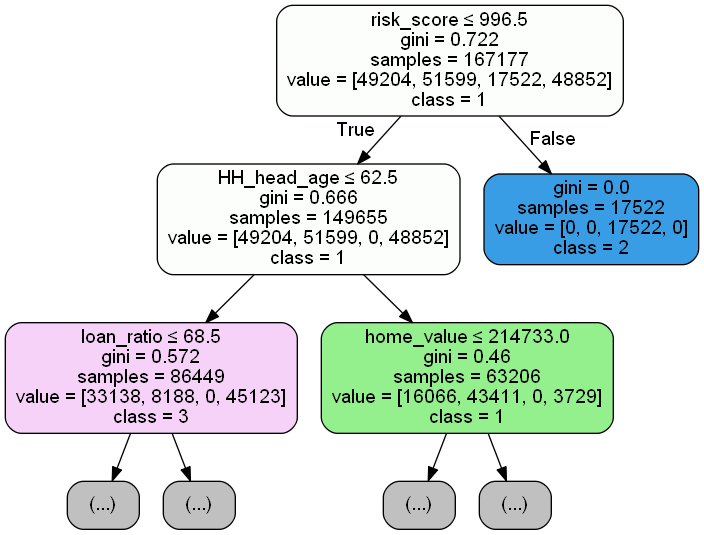

In [54]:
from sklearn.tree import DecisionTreeClassifier

os.environ["path"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

clf_hh = DecisionTreeClassifier()
clf_hb = DecisionTreeClassifier()

clf_hh.fit(clusters[family], clusters['hh'])
clf_hb.fit(clusters[hobby], clusters['hb'])

import pydotplus
from IPython.display import Image
import sklearn.tree as tree
import graphviz

dot_hh = tree.export_graphviz(
    clf_hh,
    out_file=None,
    feature_names=family,
    class_names=['0','1','2','3'],
    max_depth=2,
    filled=True,
    rounded=True,
    special_characters=True
)

graph_hh = pydotplus.graph_from_dot_data(dot_hh)
Image(graph_hh.create_png())

It can be seen from the above decision tree:

The distinguishing characteristics of users with the tag hh=0 (ie the group with class=0) are that they are relatively young and have less loan pressure

The distinguishing feature of users with the label hh=1 (ie, the group with class=3) is that they live longer and have average economic conditions

The distinguishing characteristics of users with the label hh=2 (ie, the group with class=3) are that they live longer and have higher credit risks.

The outstanding feature of users with the tag hh=3 (ie, the group with class=3) is that they have low credit risk and are relatively young

## Interest and hobby

In [55]:
# interest/hobby
attr = ['Group 1','Group 2','Group 3']
v2 = data_HB.groupby('type').count().iloc[:,1]
pie = Pie("Interest and hobby attribute classification group proportion")
pie.add("", attr, v2, is_label_show=True,radius=[20, 60])
pie

In [56]:
hb = data_HB.groupby('type').mean()

c_schema=[]
for i in hb.columns:
    dict = {}
    dict['name'] = i
    dict['max'] = 2
    dict['min'] = -1
    c_schema.append(dict)
radar = Radar()
color = ['#50514F','#F25F5C','#FFE066']
radar.config(c_schema=c_schema,shape='circle')
for i in range(3):
    radar.add('Group%i'%(i+1),[hb.iloc[i]],is_area_show=True,area_opacity=0.6,area_color=color[i])
radar


Observing the above figure, three clusters can be obtained:

Group 1: Not paying attention to appearance and daily health, like leisure and entertainment

Group 2: Little exercise and leisure, not paying attention to figure, likes staying at home

Group 3: Care about body and health, like sports and fitness

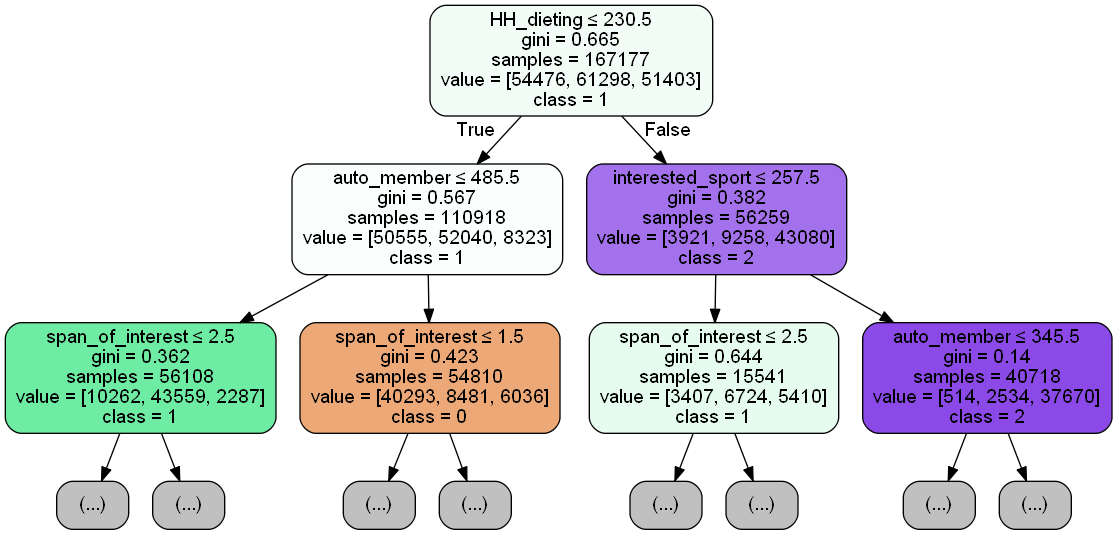

In [57]:
dot_hb = tree.export_graphviz(
    clf_hb,
    out_file=None,
    feature_names=hobby,
    class_names=['0','1','2'],
    max_depth=2,
    filled=True,
    rounded=True,
    special_characters=True
)

graph_hb = pydotplus.graph_from_dot_data(dot_hb)
Image(graph_hb.create_png())

It can be seen from the above decision tree:

The prominent feature of users with the tag hb=0 (ie the group with class=0) is their preference for car clubs

The prominent feature of users with the tag hb=1 (ie the group with class=1) is that they have a wide range of hobbies and no special preference

The prominent feature of users with the tag hb=2 (ie the group with class=2) is that they pay more attention to exercise and health management

In [72]:
ana = clusters.groupby(['hh','hb']).mean()
ana.columns = ['HH_age','loan_ration','home_value','risk_score','marital',
               'interested_sport','HH_grandparent','HH_dieting','age','auto_member',
               'HH_adults','span_of_interest']
c_schema=[]
for i in ana.columns:
    dict = {}
    dict['name'] = i
    dict['max'] = ana[i].values.max()
    dict['min'] = ana[i].values.min()
    c_schema.append(dict)
radar = Radar()
radar.config(c_schema=c_schema,shape='circle')
for i in range(12):
    radar.add('Group%i'%(i+1),[ana.iloc[i].values.tolist()],is_area_show=True,area_opacity=0.6)
radar

According to the clustering model, a corresponding marketing strategy can be simulated:

| Customer base | Feature | Product focus     |
| :---        |    :----:   |          ---: |
| hh=0,hb=0       | Young, married, support pressure and loan repayment pressure, have lots of hobbies       | Installment payment, convenience   |
| hh=1,hb=0    |  Young, married, support pressure and loan repayment pressures        | Convenience      |
| hh=2,hb=0    |Young, married, support pressure and loan repayment pressure, focus on the quality of life       | Convenience      |
| hh=3,hb=0       | Old, with a wide range of hobbies, have lots of hobbies       | Personalized, flagship product   |
| hh=0,hb=1    | Old, have stable living house, no preference        | Convenience      |
| hh=1,hb=1       | Old, have lots of interests, focus on the quality of life       | Cost-effective, installment payment   |
| hh=2,hb=1    | Old, have some hobbies, however high in risk_score        | Convenience      |
| hh=3,hb=1    |  Old, hign in risk_score, no specific preference  | Convenience      |
| hh=0,hb=2    | Middle-aged, single, middle class, like leisure and sports, however high in risk_socre        | Personalized, cost-effective      |
| hh=1,hb=2    | Young, have lots of interests and stable living house        | Personalized and cost-effective      |
| hh=2,hb=2    | Young, have stable living house        | Personalized      |
| hh=3,hb=2    | Young, middle class, like leisure and sports, with many family members        | Personalized      |